What is Pancake Prediction?
Pancake Prediction is a feature within PancakeSwap, a popular decentralized finance (DeFi) platform built on the Binance Smart Chain. This feature allows users to predict whether the price of certain cryptocurrencies, specifically CAKE and BNB, will rise or fall within a specified time frame, usually every five minutes.

Users participate in Pancake Prediction v2 by selecting either an 'Enter UP' option if they believe the price will rise, or an 'Enter DOWN' option if they think it will fall. To make a prediction, users commit a certain amount of BNB or CAKE tokens. If their prediction is correct, they win a reward, which is deposited into their digital wallee


It's important to note that PancakeSwap, including its prediction feature, operates as a decentralized exchange, meaning it doesn't have a central authority overseeing it. The platform earns revenue by charging a small trading fee on each transaction, which is then split between liquidity providers and the PancakeSwap t

Pancake Prediction v2 on PancakeSwap shares similarities with binary options trading. Both involve predicting the direction of an asset's price movement within a specified time frame (5 minutes). If your prediction is correct, you win a reward; if not, you lose your investment.d: Both are high-risk and high-reward activities. The simplicity of the decision (up or down) masks the difficulty of making accurate predictions, especially in short time frame

Link: https://pancakeswap.finance/prediction?token=CAKE

# Collecting the data
First we have to get all the needed data. We will use web3py with Pancake bet contract (0x0E3A8078EDD2021dadcdE733C6b4a86E51EE8f07) and requests with bscscan API.

Add needed modules folders:

In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

if module_path + '/src' not in sys.path:
    sys.path.append(module_path + '/src')

# os.chdir("..")

print(os.getcwd())

Install dependencies from the requirements.txt file

In [ ]:
!pip install  -r ../requirements.txt

## Getting active players
Use get_active_players.py main() with start and end time. It may be required to change the main function loop to iterate through more past transactions.
Also change CURRENT_BLOCK_NUMBER to the current one - to start checking transactions before this block.

In [ ]:
import datetime

import get_active_players

# The same timeframe as for the training set
time_from_active_players = int(datetime.datetime(2022, 10, 28, 0, 0).timestamp())
time_to_active_players = int(datetime.datetime(2022, 12, 28, 0, 0).timestamp())
active_players_file = f'../data/active_players_2months.csv'

get_active_players.make_active_players_file(time_from_active_players, time_to_active_players, 70, active_players_file)

List of active players and their occurence within given timeframe:

In [ ]:
import pandas as pd
active_players_df = pd.read_csv(active_players_file, index_col=False)

active_players_df

Let's select only players that have made more than 100 bets in the selected timeframe.

In [ ]:
# List of players to download data of (you can get them from the "Getting active players" section or from the Pancake Prediction leaderboard)
main_wallets_list = active_players_df.loc[active_players_df['count'] > 100, 'player'].tolist()
print(f"Selected {len(main_wallets_list)} wallets")


## Downloading and preparing the data

### All needed variables

In [ ]:
# Timeframe to do all the computing (Training + Validation + Test sets)
time_from_get_bets = int(datetime.datetime(2022, 10, 28, 0, 0).timestamp())
time_to_get_bets = int(datetime.datetime(2023, 1, 28, 0, 0).timestamp())

  # to get all the transactions from bscscan api (depends on the time_from_get_bets)
block_from_get_bets = 22394098
block_to_get_bets = 25624791

# Downloading players bet history settings
players_data_folder = '../data/players_data/'

# Download rounds settings (check the rounds range according to the time_from_get_bets and time_to_get_bets values in the blockchain)
from_round = 36000
to_round = 65000
rounds_file = '../data/rounds_data/final_rounds_data.csv'

# Final data
final_data_folder = '../data/merged_data/'

### Downloading players bet history
We have to collect every needed player transaction data and save to separate JSON files.

In [ ]:
import download_players_bets
print(len(main_wallets_list))
download_players_bets.main_concurrent(main_wallets_list, players_data_folder, block_from_get_bets, block_to_get_bets)

### Downloading rounds history
Use web3py to download all the rounds info and save it to the file.

In [ ]:
import download_rounds
downloader = download_rounds.RoundsDownloader()

data = downloader.download_rounds(from_round, to_round)  # Download rounds FROM-TO, we only need the last few months
downloader.save_rounds(rounds_file, data)

## Preparing the data
Before using all the data we have to create dataframes in CSV files with all the needed stuff in one place
The data will be stored in 2 saparate CSV files - one containing the info about the bet type of each analyzed player, the other one about the bet size

In [ ]:
import analyze_players

rounds_df = analyze_players.load_rounds_data(rounds_file)
    
analyze_players.create_final_csv_files(players_data_folder, final_data_folder, rounds_df)

final_bet_amount.csv file contains data about all the rounds and separate columns for each players bet amount

In [ ]:
final_bet_amount_df = pd.read_csv(f'{final_data_folder}final_bet_amount.csv')
final_bet_amount_df

final_bet_amount.csv file contains data about all the rounds and separate columns for each players bet amount

In [ ]:
final_player_bet_df = pd.read_csv(f'{final_data_folder}final_player_bet.csv', low_memory=False)
final_player_bet_df

## Selecting the best players
We have collected the data about the active players in the given dataframe, but not all players are worth following. Let's check what players have high win ratio or made the most money

### Selecting the timeframe for training&validation&test sets
We have downloaded the data in timeframe:
2022.10.28 - 2023.01.28

Let's make the first 2 months to be the training set, 1/2 month validation set and 1/2 month test set

In [ ]:
import datetime
import pandas as pd
import numpy as np

time_from_training = int(datetime.datetime(2022, 10, 28, 0, 0).timestamp())
time_to_training = int(datetime.datetime(2022, 12, 28, 0, 0).timestamp())

time_from_validation = int(datetime.datetime(2022, 12, 28, 0, 0).timestamp())
time_to_validation = int(datetime.datetime(2023, 1, 13, 0, 0).timestamp())

time_from_test = int(datetime.datetime(2023, 1, 13, 0, 0).timestamp())
time_to_test = int(datetime.datetime(2023, 1, 28, 0, 0).timestamp())


### Players metrics
Let's check how many bets were actually good for each player (win ratio) and how many CAKE tokens each player earned in total and per bet. To not affect the test set, consider only data in the training set timeframe.

In [ ]:
import check_players_results
import utils

player_bet_df, bet_amount_df = utils.load_players_data(time_from_training, time_to_training)

players_metrics_df = check_players_results.get_players_metrics(player_bet_df, bet_amount_df)
players_metrics_df.sort_values(by='total_profit', ascending=False)

In [ ]:
players_metrics_df[['total_profit', 'profit_per_bet']].hist(bins=20)

# Training the models

Now we can use all the collected data for simulation purposes.


## Simulating the environment
Since placing a bet affects the game environment (when you add money to the pool, the payout multipliers change) we have to use a simulator

### Copytrading each player
Copytrading one player at a time, works similar to just calculating his overall profit - but if we place a bet we make changes to the environment and change the pool. So if we place the same bet as player X, both of us will make less money (assuming we win) than if he played alone.

In [ ]:
import simulator
player_bet_df, bet_amount_df = utils.load_players_data(time_from_training, time_to_training)

# Get all wallets from player_bet_df
wallets = player_bet_df.columns.to_list()
not_players_list = ['epoch', 'start_timestamp', 'lock_timestamp', 'close_timestamp', 'lock_price', 'close_price',
                    'total_amount', 'bull_amount', 'bear_amount', 'position']
wallets = [wallet for wallet in wallets if wallet not in not_players_list]

data = []
for wallet in wallets:
    trades_data = simulator.copy_trade_player(player_bet_df, bet_amount_df, wallet)
    data.append({'wallet': wallet, 'profit': trades_data['profit'].sum()})

df = pd.DataFrame(data)

df.sort_values(by='profit', ascending=False)

In [ ]:
# Histogram with the profit results, we can see the curve is Gaussian-like
df['profit'].hist(bins=50)

### Simulation hyperparameters
We can bet different amount of money on each round, affecting the pool sizes and finally our and other players outcome. Not all rounds are worth betting - when we bet for Bull and there are 100$\$$ in total in the Bull pool and 5$\$$ in the Bear pool our potential profits are small but still we can loose 100% of the money invested. Thats why we should consider 2 additional hyperparameters: size of our bet (for simplicity it will be a fixed value in CAKE tokens, but in the future it could be calculated with soem formula) and minimal potential profit (as multiplier) that is needed to place a bet. These parameters will be tuned after choosing the most accurate models.

In [ ]:
bet_size=1
min_multiplier=1.0

## Preparing the data to be used in the ml

### Exploring the data
For learning process we will use the data from the 2 previous CSV files.
The data will be divided into 3 sets, based on the datetime (as its a timeseries data): the first method will be used with Pytorch model, the second one with scikitlearn, as we will need to tune the hyperparameters with k-fold cross-validation.
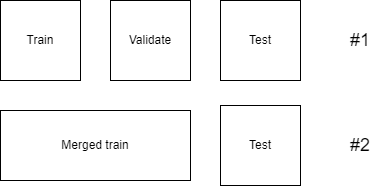 

In [ ]:
train_player_bet_df, train_bet_amount_df = utils.load_players_data(time_from_training, time_to_training)
train_player_bet_df = train_player_bet_df.drop(columns=['start_timestamp', 'lock_timestamp', 'close_timestamp', 'lock_price', 'close_price', 'total_amount', 'bull_amount', 'bear_amount', 'position'])
train_df = train_player_bet_df.merge(train_bet_amount_df, on = 'epoch', suffixes=['_bet','_amount'])
train_df = train_df.set_index('epoch')
train_df

In [ ]:
validate_player_bet_df, validate_bet_amount_df = utils.load_players_data(time_from_validation, time_to_validation)
validate_player_bet_df = validate_player_bet_df.drop(columns=['start_timestamp', 'lock_timestamp', 'close_timestamp', 'lock_price', 'close_price', 'total_amount', 'bull_amount', 'bear_amount', 'position'])
validate_df = validate_player_bet_df.merge(validate_bet_amount_df, on = 'epoch', suffixes=['_bet','_amount'])
validate_df = validate_df.set_index('epoch')
validate_df

In [ ]:
test_player_bet_df, test_bet_amount_df = utils.load_players_data(time_from_test, time_to_test)
test_player_bet_df = test_player_bet_df.drop(columns=['start_timestamp', 'lock_timestamp', 'close_timestamp', 'lock_price', 'close_price', 'total_amount', 'bull_amount', 'bear_amount', 'position'])
test_df = test_player_bet_df.merge(test_bet_amount_df, on = 'epoch', suffixes=['_bet','_amount'])
test_df = test_df.set_index('epoch')
test_df

Let's check if the dataset is balanced

In [ ]:
train_df['position'].value_counts()

In [ ]:
validate_df['position'].value_counts()

In [ ]:
test_df['position'].value_counts()

The dataset seems to be well balanced

As we will use k-fold cross-validation for the hyperparameter tuning of the sklearn models, we can merge the train and validation datasets. The final performance of the model will be checked on the test dataset.

In [ ]:
merged_train_player_bet_df, merged_train_bet_amount_df = utils.load_players_data(time_from_training, time_to_validation)
merged_train_player_bet_df = merged_train_player_bet_df.drop(columns=['start_timestamp', 'lock_timestamp', 'close_timestamp', 'lock_price', 'close_price', 'total_amount', 'bull_amount', 'bear_amount', 'position'])
merged_train_df = merged_train_player_bet_df.merge(merged_train_bet_amount_df, on = 'epoch', suffixes=['_bet','_amount'])
merged_train_df = merged_train_df.set_index('epoch')
merged_train_df

In [ ]:
merged_train_df['position'].value_counts()

### Cleaning the data before the training
1. Because NaN values provide no information we can delete all the rows that contain only NaNs. This would work in the production environment as if we get no information about the current round we can simply pass that round (so we don't place any bet).
2. For the simplicity we will remove all the rows with 'position' == 'House' so we end up with a binary classification problem. Later, when finally testing the model we will add this category once again (when its House you lose no matter if you place a bet for Bull or Bea
3. Do not consider transaction fees. Because many players are bots and they place their bet in the last few seconds of the round, in the production environment we should use higher gas price to be able to place the bet just after recording all the other players bets. The transaction cost per every bet will be 0.05 $\$$ -0.2 $\$$ r)

### Choosing the feature sets
We will check few types of features sets to check which one provides the most useful information about the label.
- total pool sizes for Bear/Bull bets (no additional info about the player: 2 columns in total (these features will be added to ALL feture sets below)s)
- all 247 players bet info (Bull/Bear): 247 columns in total
- all 247 players bet info (Bull/Bear) + their bet size info (in CAKE tokens): 247*2 = 494 columns in total
- the best 10% of players bet info (Bull/Bear) according to their overall profit
- the best 10% of players bet info (Bull/Bear) according to their overall profit + their bet size info (in CAKE tokens)
- the best 20% of players bet info (Bull/Bear) according to their overall profit
- the best 20% of players bet info (Bull/Bear) according to their overall profit + their bet size info (in CAKE tokens)
- total amount of CAKE tokens bets for Bull/Bear of the best 10% of players + total number of bets (Bull/Bear) of the best 10% of players: 4 columns in total
- total amount of CAKE tokens bets for Bull/Bear of the best 20% of players + total number of bets (Bull/Bear) of the best 20% of players: 4 columns in total

In [ ]:
# Lists of the best players (by total profit)
# There are 247 wallets in total, lets check how many is 10% and 20%
p10 = int(len(players_metrics_df)*0.1)
p20 = int(len(players_metrics_df)*0.2)
print(p10, p20)

best_10p_players_list = players_metrics_df.sort_values(by='total_profit', ascending=False).reset_index(drop=True).loc[:p10-1, 'player'].values.tolist()
best_20p_players_list = players_metrics_df.sort_values(by='total_profit', ascending=False).reset_index(drop=True).loc[:p20-1, 'player'].values.tolist()

In [ ]:
# Get the needed columns names in the lists
all_players_bet_cols = [col+'_bet' for col in main_wallets_list]
all_players_amount_cols = [col+'_amount' for col in main_wallets_list]

best_10p_players_bet_cols = [col+'_bet' for col in best_10p_players_list]
best_10p_players_amount_cols = [col+'_amount' for col in best_10p_players_list]

best_20p_players_bet_cols = [col+'_bet' for col in best_20p_players_list]
best_20p_players_amount_cols = [col+'_amount' for col in best_20p_players_list]

In [ ]:
def prepare_data(df, cols_to_leave_arg):
    cols_to_leave = cols_to_leave_arg.copy()  # Make a copy of the list to not remove the elements from the original list

    df = df[df["position"] != "House"]  # To make the problem binary classification
    df = df[df["total_amount"] != 0]  # Do not consider the rounds where no one bet
    df = df[cols_to_leave]

    # Remove nan rows (where none from selected players placed any bet)
    not_nan_cols = ['position', 'bull_amount', 'bear_amount']
    for element in not_nan_cols:
        cols_to_leave.remove(element)

    if len(cols_to_leave) > 0:
        df = df.dropna(subset=cols_to_leave, how='all')

    # Get the list of the categorical cols and do one hot encoding
    categorical_cols = df.select_dtypes(include=['category']).columns.to_list()
    categorical_cols.remove('position')

    for col in categorical_cols:
        one_hot_encoded_cols = pd.get_dummies(df[col], prefix_sep='_', prefix=col)

        # Drop column with 'House' in the name (as the player can only bet on Bull or Bear)
        one_hot_encoded_cols = one_hot_encoded_cols.drop([col + '_House'], axis=1)
        df = df.drop([col], axis=1).join(one_hot_encoded_cols)

    # Fill numeric columns with 0 (bet amount cols)
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].fillna(0)

    df = df.replace("Bull", 1)
    df = df.replace("Bear", 0)

    df = df.replace("House", np.nan)  # Although the House rows are dropped, we have to replace it to remove the category
    df = df.astype(float)

    # df.reset_index(drop=True, inplace=True)

    return df

In [ ]:
feature_set1 = ['bull_amount', 'bear_amount', 'position']
feature_set1_train_df = prepare_data(train_df, feature_set1)
feature_set1_validate_df = prepare_data(validate_df, feature_set1)
feature_set1_test_df = prepare_data(train_df, feature_set1)
feature_set1_merged_train_df = prepare_data(merged_train_df, feature_set1)

feature_set2 = all_players_bet_cols.copy() # Keep the features from the feature_set_1 as they have predicting power
feature_set2.extend(feature_set1)
feature_set2_train_df = prepare_data(train_df, feature_set2)
feature_set2_validate_df = prepare_data(validate_df, feature_set2)
feature_set2_test_df = prepare_data(train_df, feature_set2)
feature_set2_merged_train_df = prepare_data(merged_train_df, feature_set2)

feature_set3 = all_players_bet_cols.copy() + all_players_amount_cols.copy()
feature_set3.extend(feature_set1)
feature_set3_train_df = prepare_data(train_df, feature_set3)
feature_set3_validate_df = prepare_data(validate_df, feature_set3)
feature_set3_test_df = prepare_data(train_df, feature_set3)
feature_set3_merged_train_df = prepare_data(merged_train_df, feature_set3)

feature_set4 = best_10p_players_bet_cols.copy()
feature_set4.extend(feature_set1)
feature_set4_train_df = prepare_data(train_df, feature_set4)
feature_set4_validate_df = prepare_data(validate_df, feature_set4)
feature_set4_test_df = prepare_data(train_df, feature_set4)
feature_set4_merged_train_df = prepare_data(merged_train_df, feature_set4)

feature_set5 = best_10p_players_bet_cols.copy() + best_10p_players_amount_cols.copy()
feature_set5.extend(feature_set1)
feature_set5_train_df = prepare_data(train_df, feature_set5)
feature_set5_validate_df = prepare_data(validate_df, feature_set5)
feature_set5_test_df = prepare_data(train_df, feature_set5)
feature_set5_merged_train_df = prepare_data(merged_train_df, feature_set5)

feature_set6 = best_20p_players_bet_cols.copy()
feature_set6.extend(feature_set1)
feature_set6_train_df = prepare_data(train_df, feature_set6)
feature_set6_validate_df = prepare_data(validate_df, feature_set6)
feature_set6_test_df = prepare_data(train_df, feature_set6)
feature_set6_merged_train_df = prepare_data(merged_train_df, feature_set6)

feature_set7 = best_20p_players_bet_cols.copy() + best_20p_players_amount_cols.copy()
feature_set7.extend(feature_set1)
feature_set7_train_df = prepare_data(train_df, feature_set7)
feature_set7_validate_df = prepare_data(validate_df, feature_set7)
feature_set7_test_df = prepare_data(train_df, feature_set7)
feature_set7_merged_train_df = prepare_data(merged_train_df, feature_set7)

In [ ]:
def create_aggregated_df(df, bet_type_columns, bet_size_columns, additional_columns):
    filtered_df = df[bet_size_columns + bet_type_columns + ['total_amount'] + additional_columns].copy()

    # Calculate Bear number for each row
    filtered_df['best_bear_number'] = filtered_df[bet_type_columns].isin(['Bear']).sum(axis=1)
    filtered_df['best_bull_number'] = filtered_df[bet_type_columns].isin(['Bull']).sum(axis=1)

    filtered_df['best_bear_amount'] = 0
    filtered_df['best_bull_amount'] = 0

    # Replace NaN with 0 in the bet size columns
    filtered_df[bet_size_columns] = filtered_df[bet_size_columns].fillna(0)

    # Iterate through each wallet's columns to aggregate the data
    for bet_type_column in bet_type_columns:
        bet_size_column = bet_type_column.replace('_bet', '_amount')

        wallet_df = filtered_df[[bet_size_column, bet_type_column]]

        bear_bets = np.where(wallet_df[bet_type_column] == 'Bear', wallet_df[bet_size_column], 0)
        bull_bets = np.where(wallet_df[bet_type_column] == 'Bull', wallet_df[bet_size_column], 0)

        filtered_df['best_bear_amount'] += bear_bets
        filtered_df['best_bull_amount'] += bull_bets

    # Drop rows where all columns are 0
    filtered_df = filtered_df[(filtered_df[bet_size_columns] != 0).any(axis=1)]

    return filtered_df

In [ ]:
# We need separate function for these 2
feature_set8 = ['best_bear_number', 'best_bull_number', 'best_bear_amount', 'best_bull_amount']
feature_set8.extend(feature_set1)
feature_set8_train_df = create_aggregated_df(train_df, best_10p_players_bet_cols, best_10p_players_amount_cols, feature_set1.copy())
feature_set8_validate_df = create_aggregated_df(validate_df, best_10p_players_bet_cols, best_10p_players_amount_cols, feature_set1.copy())
feature_set8_test_df = create_aggregated_df(test_df, best_10p_players_bet_cols, best_10p_players_amount_cols, feature_set1.copy())
feature_set8_merged_train_df = create_aggregated_df(merged_train_df, best_10p_players_bet_cols, best_10p_players_amount_cols, feature_set1.copy())

feature_set8_train_df = prepare_data(feature_set8_train_df, feature_set8)
feature_set8_validate_df = prepare_data(feature_set8_validate_df, feature_set8)
feature_set8_test_df = prepare_data(feature_set8_test_df, feature_set8)
feature_set8_merged_train_df = prepare_data(feature_set8_merged_train_df, feature_set8)

feature_set9 = feature_set8
feature_set9_train_df = create_aggregated_df(train_df, best_20p_players_bet_cols, best_20p_players_amount_cols, feature_set1.copy())
feature_set9_validate_df = create_aggregated_df(validate_df, best_20p_players_bet_cols, best_20p_players_amount_cols, feature_set1.copy())
feature_set9_test_df = create_aggregated_df(test_df, best_20p_players_bet_cols, best_20p_players_amount_cols, feature_set1.copy())
feature_set9_merged_train_df = create_aggregated_df(merged_train_df, best_20p_players_bet_cols, best_20p_players_amount_cols, feature_set1.copy())

feature_set9_train_df = prepare_data(feature_set9_train_df, feature_set9)
feature_set9_validate_df = prepare_data(feature_set9_validate_df, feature_set9)
feature_set9_test_df = prepare_data(feature_set9_test_df, feature_set9)
feature_set9_merged_train_df = prepare_data(feature_set9_merged_train_df, feature_set9)

Print the feature sets info

In [ ]:
feature_sets_dfs_list = [feature_set1_merged_train_df, feature_set2_merged_train_df, feature_set3_merged_train_df, feature_set4_merged_train_df, feature_set5_merged_train_df, feature_set6_merged_train_df, feature_set7_merged_train_df, feature_set8_merged_train_df, feature_set9_merged_train_df]

for i, feature_set_df in enumerate(feature_sets_dfs_list):
    print(f"--- Feature set {i+1} Total: {feature_set_df.shape[1]} ---")
    print(feature_set_df.columns.to_list())

### Removing the outliers
All possible outliers represent natural variations and they will be left in the dataset

In [ ]:
merged_train_df.describe()

In [ ]:
train_df.describe()

In [ ]:
validate_df.describe()

In [ ]:
test_df.describe()

### Feature scaling
The columns containing info about each players bet type (Bull/Bear or None, so categorical data) have been One-Hot encoded. The rest of the columns containing info about each players bet size (so numerical data) need to be scaled. Let's check the distribution of some random columns to choose the scaler.

In [ ]:
print(feature_set1_merged_train_df.columns)
feature_set1_merged_train_df.iloc[:, 0].hist(range=(0,100), bins=20)

In [ ]:
print(feature_set3_merged_train_df.columns)
feature_set3_merged_train_df.iloc[:, 15].hist(range=(0,5), bins=20)

In [ ]:
print(feature_set5_merged_train_df.columns)
feature_set5_merged_train_df.iloc[:, 25].hist(range=(0,100), bins=20)

In [ ]:
print(feature_set7_merged_train_df.columns)
feature_set7_merged_train_df.iloc[:, 32].hist(range=(0,15), bins=20)

In [ ]:
print(feature_set9_merged_train_df.columns)
feature_set9_merged_train_df.iloc[:, 0].hist(range=(0,15), bins=20)

In [ ]:
feature_set9_merged_train_df.iloc[:, 2].hist(range=(0,15), bins=20)

The data distribution seems to not be normal, so we will use the MinMaxScaler from the scikit-learn library. The scaler have to be fit on the training data, then used to scale the training, validation and test data.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def scale_amount_columns(merged_train_df, train_df, validate_df, test_df):
    # Train MinMaxScalers for each training dataset
    scaler = MinMaxScaler().set_output(transform="pandas")

    # Basically we want to scale all the columns that contain 'amount' or 'number' substring
    substrings = ['amount', 'number']
    columns_to_scale = [col for col in train_df.columns if any(sub in col for sub in substrings)]

    # Fit the scalers on each feature set training data
    merged_train_df[columns_to_scale] = scaler.fit_transform(merged_train_df[columns_to_scale])
    train_df[columns_to_scale] = scaler.fit_transform(train_df[columns_to_scale])
    validate_df[columns_to_scale] = scaler.transform(validate_df[columns_to_scale])
    test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

    return merged_train_df, train_df, validate_df, test_df

feature_set1_merged_train_df, feature_set1_train_df, feature_set1_validate_df, feature_set1_test_df = scale_amount_columns(feature_set1_merged_train_df, feature_set1_train_df, feature_set1_validate_df, feature_set1_test_df)
feature_set2_merged_train_df, feature_set2_train_df, feature_set2_validate_df, feature_set2_test_df = scale_amount_columns(feature_set2_merged_train_df, feature_set2_train_df, feature_set2_validate_df, feature_set2_test_df)
feature_set3_merged_train_df, feature_set3_train_df, feature_set3_validate_df, feature_set3_test_df = scale_amount_columns(feature_set3_merged_train_df, feature_set3_train_df, feature_set3_validate_df, feature_set3_test_df)
feature_set4_merged_train_df, feature_set4_train_df, feature_set4_validate_df, feature_set4_test_df = scale_amount_columns(feature_set4_merged_train_df, feature_set4_train_df, feature_set4_validate_df, feature_set4_test_df)
feature_set5_merged_train_df, feature_set5_train_df, feature_set5_validate_df, feature_set5_test_df = scale_amount_columns(feature_set5_merged_train_df, feature_set5_train_df, feature_set5_validate_df, feature_set5_test_df)
feature_set6_merged_train_df, feature_set6_train_df, feature_set6_validate_df, feature_set6_test_df = scale_amount_columns(feature_set6_merged_train_df, feature_set6_train_df, feature_set6_validate_df, feature_set6_test_df)
feature_set7_merged_train_df, feature_set7_train_df, feature_set7_validate_df, feature_set7_test_df = scale_amount_columns(feature_set7_merged_train_df, feature_set7_train_df, feature_set7_validate_df, feature_set7_test_df)
feature_set8_merged_train_df, feature_set8_train_df, feature_set8_validate_df, feature_set8_test_df = scale_amount_columns(feature_set8_merged_train_df, feature_set8_train_df, feature_set8_validate_df, feature_set8_test_df)
feature_set9_merged_train_df, feature_set9_train_df, feature_set9_validate_df, feature_set9_test_df = scale_amount_columns(feature_set9_merged_train_df, feature_set9_train_df, feature_set9_validate_df, feature_set9_test_df)

In [ ]:
# Check if the min-max values are 0-1
feature_set2_merged_train_df.describe()

In [ ]:
feature_set9_merged_train_df.describe()

### Threshold
As after removing the rounds with 'House' position we end up with binary classification problem, we want to leave it like that. But in production environment we can bet Bull/Bear or pass the round without betting and wait for for the model to give confident prediction.
We can get the probability for each class with sklearn function predict_proba. 0.5-0.5 means the model is completely not sure which class to choose, while 0.9-0.1 means its high probability that the record will be classified as the first class.
Let's add another hyperparameter - threshold. The model will return a class label only when the probability will be higher than the threshold. Threshold can be in range of 0.5-1, however we have to determine it experimentally.

## Testing the scikit-learn models

In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit

def run(k, models_name, amount_data_df, x_train, y_train, x_test, y_test, clf, threshold=0.7, bet_size=1, min_multiplier=0):
    # Check if the model already exists
    model_name = f"{models_name}_{str(clf)}_k{k}.pkl"
    model_dir = f"../models/{model_name}"

    if os.path.exists(model_dir):
        print(f"Loading the model {model_dir}")
        with open(model_dir, 'rb') as f:
            clf = pickle.load(f)
    else:
        print(f"Training the model {clf}")
        clf.fit(x_train, y_train)
    clf.fit(x_train, y_train)

    total_accuracy = clf.score(x_test, y_test)

    predicted_probability = clf.predict_proba(x_test)

    # Create a df to compare the predicted_probability with the real y_test
    df = pd.DataFrame(predicted_probability, columns=["Bear", "Bull"], index=y_test.index)
    df["position"] = y_test.values
    df["predicted_position"] = np.where(df["Bear"] > threshold, 0, np.nan)
    df["predicted_position"] = np.where(df["Bull"] > threshold, 1, df["predicted_position"])

    df["correct"] = np.where(df["position"] == df["predicted_position"], 1, 0)

    df['bull_amount'] = amount_data_df['bull_amount']
    df['bear_amount'] = amount_data_df['bear_amount']
    df['total_amount'] = amount_data_df['total_amount']
    
    simulation_results_df = simulator.simulate(df[['position', 'bull_amount', 'bear_amount', 'total_amount']], df['predicted_position'], bet_size=bet_size, add_bet_to_pool = True, min_multiplier = min_multiplier)

    # Drop rows where prediction is null and calculate the total profit
    simulation_results_df = simulation_results_df[simulation_results_df['prediction'].notna()]
    profit = simulation_results_df['profit'].sum()

    played_rounds = (simulation_results_df['profit'] != 0).sum()
    
    # Get accuracy when probability is above threshold
    accuracy = df["correct"].sum() / (df['predicted_position'].count() + 0.0000001)  # Count only not NaN values

    # Calculate the F1 score
    df['prediction_position_all'] = np.where(df["Bear"] > df["Bull"], 0, 1)
    score = f1_score(df["position"], df['prediction_position_all'], average="macro")

    # Save the model
    if not os.path.exists(model_dir):
        with open(model_dir,'wb') as f:
            print(f"Saving the model {model_dir}")
            pickle.dump(clf, f)

    return {'classifier': str(clf), 'threshold': threshold, 'total_accuracy': total_accuracy, "total_f1_score": score,
            'total_number_of_bets': len(y_test), 'accuracy_above_threshold': accuracy,
            'number_of_bets_above_threshold': df['predicted_position'].count(), 'total_number_of_bets_placed': played_rounds, 'profit': profit}


def main(models_name, amount_data_df, merged_train_df, clfs, threshold_list, cols_to_leave, bet_size=1, min_multiplier=0, k=10):
    # k-fold cross-validation made for time series
    tscv = TimeSeriesSplit(n_splits=k)
    X, y = merged_train_df.drop(["position"], axis=1), merged_train_df["position"]

    data_list = []

    for clf in clfs:
        print(f'Classifier: {clf}')
        for threshold in threshold_list:
            print(f'Threshold: {threshold}')

            kfold_data_list = []

            current_k = 1
            for train_index, test_index in tscv.split(X):
                print(f'K: {current_k}')
                print(f'indexes: train: {train_index} test:{test_index}')
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                data = run(current_k, models_name, amount_data_df, X_train, y_train, X_test, y_test, clf, threshold, bet_size, min_multiplier)
                kfold_data_list.append(data)

                current_k += 1

            # Calculate the mean values
            mean_data = kfold_data_list[0]
            mean_data['total_accuracy'] = sum(d['total_accuracy'] for d in kfold_data_list) / len(kfold_data_list)
            mean_data['total_f1_score'] = sum(d['total_f1_score'] for d in kfold_data_list) / len(kfold_data_list)
            mean_data['total_number_of_bets'] = sum(d['total_number_of_bets'] for d in kfold_data_list) / len(kfold_data_list)
            mean_data['number_of_bets_above_threshold'] = sum(d['number_of_bets_above_threshold'] for d in kfold_data_list) / len(kfold_data_list)
            mean_data['total_number_of_bets_placed'] = sum(d['total_number_of_bets_placed'] for d in kfold_data_list) / len(kfold_data_list)
            mean_data['profit'] = sum(d['profit'] for d in kfold_data_list) / len(kfold_data_list)

            if len([d['accuracy_above_threshold'] for d in kfold_data_list if not d['accuracy_above_threshold'] < 0.1]) == 0:
                mean_data['accuracy_above_threshold'] = np.nan
            else:
                mean_data['accuracy_above_threshold'] = sum(d['accuracy_above_threshold'] for d in kfold_data_list if not d['accuracy_above_threshold'] < 0.1) / len([d['accuracy_above_threshold'] for d in kfold_data_list if not d['accuracy_above_threshold'] < 0.1])

            
            data_list.append(mean_data)

    df = pd.DataFrame(data_list)
    return df

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Divide the classifiers into 2 groups (because of the training time)
clfs = [RandomForestClassifier(100), RandomForestClassifier(500), RandomForestClassifier(1000),
        DecisionTreeClassifier(criterion='entropy'), MLPClassifier(alpha=1, max_iter=1000), GaussianNB(),
        KNeighborsClassifier(3), KNeighborsClassifier(5), KNeighborsClassifier(7),
        KNeighborsClassifier(9), KNeighborsClassifier(11), LogisticRegression(max_iter=1000)]

svc_clfs = [SVC(kernel='rbf', probability=True), SVC(kernel='linear', probability=True),
            SVC(kernel='rbf', probability=True, C=10), SVC(kernel='linear', probability=True, C=10),
            SVC(kernel='rbf', probability=True, C=50), SVC(kernel='linear', probability=True, C=50)]

threshold_list = [0.6, 0.7, 0.8, 0.9, 0.95]

### Feature set #1: total pool sizes for Bear/Bull bets (no additional info about the players)

In [ ]:
experiment1_df = main(amount_data_df=merged_train_df, models_name='experiment1', merged_train_df=feature_set1_merged_train_df,
                      clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set1, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment1_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment2_df = main(amount_data_df=merged_train_df, models_name='experiment2', merged_train_df=feature_set1_merged_train_df,
                      clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set1, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment2_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #2: all 247 players bet info (Bull/Bear)

In [ ]:
experiment3_df = main(amount_data_df=merged_train_df, models_name='experiment3', merged_train_df=feature_set2_merged_train_df,
                      clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set2, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment3_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment4_df = main(amount_data_df=merged_train_df, models_name='experiment4', merged_train_df=feature_set2_merged_train_df,
                      clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set2, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment4_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #3: all 247 players bet info (Bull/Bear) + their bet size info (in CAKE tokens)

In [ ]:
experiment5_df = main(amount_data_df=merged_train_df, models_name='experiment5', merged_train_df=feature_set3_merged_train_df,
                      clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set3, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
# This features set model takes much longer to train
experiment5_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment6_df = main(amount_data_df=merged_train_df, models_name='experiment6', merged_train_df=feature_set3_merged_train_df,
                      clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set3, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
# This features set model takes much longer to train
experiment6_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #4: the best 10% of players bet info (Bull/Bear) according to their overall profit

In [ ]:
experiment7_df = main(amount_data_df=merged_train_df, models_name='experiment7', merged_train_df=feature_set4_merged_train_df,
                      clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set4, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment7_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment8_df = main(amount_data_df=merged_train_df, models_name='experiment8', merged_train_df=feature_set4_merged_train_df,
                      clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set4, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment8_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #5: the best 10% of players bet info (Bull/Bear) according to their overall profit + their bet size info (in CAKE tokens)

In [ ]:
experiment9_df = main(amount_data_df=merged_train_df, models_name='experiment9', merged_train_df=feature_set5_merged_train_df,
                      clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set5, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment9_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment10_df = main(amount_data_df=merged_train_df, models_name='experiment10', merged_train_df=feature_set5_merged_train_df,
                       clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set5, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment10_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #6: the best 20% of players bet info (Bull/Bear) according to their overall profit

In [ ]:
experiment11_df = main(amount_data_df=merged_train_df, models_name='experiment11', merged_train_df=feature_set6_merged_train_df,
                       clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set6, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment11_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment12_df = main(amount_data_df=merged_train_df, models_name='experiment12', merged_train_df=feature_set6_merged_train_df,
                       clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set6, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment12_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #7: the best 20% of players bet info (Bull/Bear) according to their overall profit + their bet size info (in CAKE tokens)

In [ ]:
experiment13_df = main(amount_data_df=merged_train_df, models_name='experiment13', merged_train_df=feature_set7_merged_train_df,
                       clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set7, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment13_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment14_df = main(amount_data_df=merged_train_df, models_name='experiment14', merged_train_df=feature_set7_merged_train_df,
                       clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set7, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment14_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #8: total amount of CAKE tokens bets for Bull/Bear of the best 10% of players + total number of bets (Bull/Bear) of the best 10% of players

In [ ]:
experiment15_df = main(amount_data_df=merged_train_df, models_name='experiment15', merged_train_df=feature_set8_merged_train_df,
                       clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set8, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment15_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment16_df = main(amount_data_df=merged_train_df, models_name='experiment16', merged_train_df=feature_set8_merged_train_df,
                       clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set8, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment16_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

### Feature set #9: total amount of CAKE tokens bets for Bull/Bear of the best 20% of players + total number of bets (Bull/Bear) of the best 20% of players

In [ ]:
experiment17_df = main(amount_data_df=merged_train_df, models_name='experiment17', merged_train_df=feature_set9_merged_train_df,
                       clfs=clfs, threshold_list=threshold_list, cols_to_leave=feature_set9, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment17_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

In [ ]:
experiment18_df = main(amount_data_df=merged_train_df, models_name='experiment18', merged_train_df=feature_set9_merged_train_df,
                       clfs=svc_clfs, threshold_list=threshold_list, cols_to_leave=feature_set9, bet_size=bet_size, min_multiplier=min_multiplier)

In [ ]:
experiment18_df.sort_values(by='accuracy_above_threshold', ascending=False).head(20)

Based on the accuracy_above_threshold and number_of_bets_above_threshold (and considering the speed of the models + the curse of dimensionality) from all the experiments, the models worth further analysing are SVC (feature set#8 and feature set #9).
The hyperparameters should be tuned, to find the real profits that are possible to be made with the model.

## Tuning the hyperparameters
I have selected 2 feature sets, the process of tuning the hyperparameters should be done separately for each of them. SVC can be tuned with:
- C
- gamma
- kernel

In addition we have to tune parameters of the simulator which are:
- bet_size
- min_multiplier
- threshold

I have to assume the pool sizes are +/- the same in all the rounds. In practice, during the bear market the pools are almost empty, and during the bull market people tend to bet more, which is better for us. That's why I have selected relatively short time periods for the data sets.

There are 6 hyperparameters to tune in total for 2 different feature sets.
To save some time I will use random search instead of grid search.

Train_df will be used to train the models, validate_df to check the performance of the tuned models (hyperparameter tuning) and the final performance will be checked with an independent test_df

Sources:
- https://otexts.com/fpp3/tscv.html
- https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4